In [184]:
# Wikimedia Toxicity Personal Attacks Multilabel Data Prep (including rev_id).
import sys
import os
from pathlib import Path
import getopt
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import msgpack
import re
import csv
from gensim.models import Word2Vec
from io import BytesIO
from tensorflow.python.lib.io import file_io

import matplotlib.pylab as plt
%matplotlib inline
sns.set(color_codes=True)

In [185]:
# Set paths.

# Default data directory.
data_dir = ''

# Default number of votes to decide label based on the annotations of the
# ten workers who annotated the dataset.
min_num_votes = 6

# Path to data directory.
data_path = Path(data_dir)

# Output path.
output_dir = Path('output')

In [186]:
# Get the data, create dataframes from the tab-separated files.
attacks_comments_path = data_path / 'attack_annotated_comments.tsv'
attacks_comments_df = pd.read_csv(attacks_comments_path, sep='\t', header=0)

attacks_labels_path = data_path / 'attack_annotations.tsv'
attacks_labels_df = pd.read_csv(attacks_labels_path, sep='\t', header=0)

In [187]:
attacks_comments_df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [188]:
attacks_labels_df.attack.unique()

array([0., 1.])

In [205]:
# Merge data frames of comments and annotations on rev_id.
attacks_merged = pd.merge(attacks_comments_df, attacks_labels_df, 
                          on='rev_id')
attacks_merged.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,1362,0.0,0.0,0.0,0.0,0.0
1,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,2408,0.0,0.0,0.0,0.0,0.0
2,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,1493,0.0,0.0,0.0,0.0,0.0
3,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,1439,0.0,0.0,0.0,0.0,0.0
4,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,170,0.0,0.0,0.0,0.0,0.0


In [206]:
attacks_merged_summed = attacks_merged.groupby('rev_id').sum()
attacks_merged_summed.drop(['year', 'logged_in', 'worker_id'], axis=1, inplace=True)
attacks_merged_summed.head()

,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
rev_id,,,,,
37675,0.0,0.0,0.0,0.0,0.0
44816,0.0,0.0,0.0,0.0,0.0
49851,0.0,0.0,0.0,0.0,0.0
89320,0.0,2.0,0.0,2.0,4.0
93890,0.0,0.0,0.0,0.0,0.0


In [207]:
# Cast floats to ints to avoid later processing errors in TF/Keras.
attacks_merged_summed.quoting_attack = pd.to_numeric(attacks_merged_summed.quoting_attack, 
              downcast='integer')
attacks_merged_summed.recipient_attack = pd.to_numeric(attacks_merged_summed.recipient_attack, 
              downcast='integer')
attacks_merged_summed.third_party_attack = pd.to_numeric(attacks_merged_summed.third_party_attack, 
              downcast='integer')
attacks_merged_summed.other_attack = pd.to_numeric(attacks_merged_summed.other_attack, 
              downcast='integer')
attacks_merged_summed.attack = pd.to_numeric(attacks_merged_summed.attack, 
              downcast='integer')
attacks_merged_summed.head()

,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
rev_id,,,,,
37675,0,0,0,0,0
44816,0,0,0,0,0
49851,0,0,0,0,0
89320,0,2,0,2,4
93890,0,0,0,0,0


In [208]:
# Despite using the same threshold as the binary version of this dataset, 5, reducing the number of
# less-frequent labels quite low, it's retained for a better comparison between the models. 
threshold = 5
print('Num quoting_attack:\t', len(attacks_merged_summed[attacks_merged_summed['quoting_attack'] > threshold]))
print('Num recipient_attack:\t', len(attacks_merged_summed[attacks_merged_summed['recipient_attack'] > threshold]))
print('Num third_party_attack:\t', len(attacks_merged_summed[attacks_merged_summed['third_party_attack'] > threshold]))
print('Num other_attack:\t', len(attacks_merged_summed[attacks_merged_summed['other_attack'] > threshold]))
print('Num attack:\t\t', len(attacks_merged_summed[attacks_merged_summed['attack'] > threshold]))

Num quoting_attack:	 7
Num recipient_attack:	 9053
Num third_party_attack:	 1042
Num other_attack:	 285
Num attack:		 14205


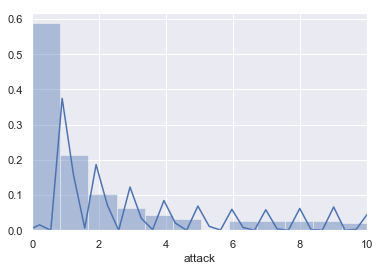

In [209]:
# Poking around the distrubutions shows the difference in frequency of the types of attacks.
plt.xlim(0, 10)
sns.distplot(attacks_merged_summed.attack)

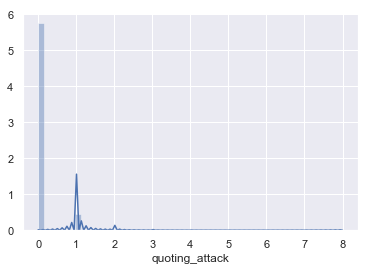

In [210]:
sns.distplot(attacks_merged_summed['quoting_attack'])

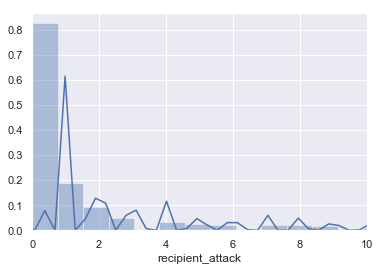

In [211]:
plt.xlim(0, 10)
sns.distplot(attacks_merged_summed['recipient_attack'])

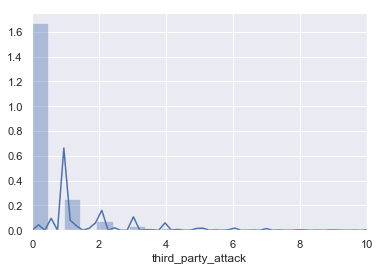

In [212]:
plt.xlim(0, 10)
sns.distplot(attacks_merged_summed['third_party_attack'])

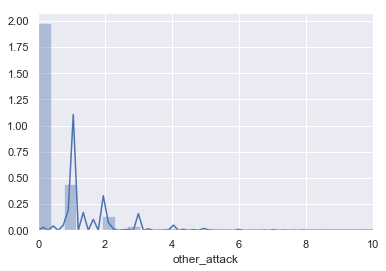

In [213]:
plt.xlim(0, 10)
sns.distplot(attacks_merged_summed.other_attack)

In [214]:
# So now to replace values > 5 with 1.
attacks_merged_summed.head()

,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
rev_id,,,,,
37675,0,0,0,0,0
44816,0,0,0,0,0
49851,0,0,0,0,0
89320,0,2,0,2,4
93890,0,0,0,0,0


In [215]:
# Set labels for each col by keeping values that match condition, 
# replace values that don't match with other. 
attacks_merged_summed.quoting_attack.where(attacks_merged_summed.quoting_attack > threshold, other=0, inplace=True)
attacks_merged_summed.quoting_attack.where(attacks_merged_summed.quoting_attack <= threshold, other=1, inplace=True)

attacks_merged_summed.recipient_attack.where(attacks_merged_summed.recipient_attack > threshold, other=0, inplace=True)
attacks_merged_summed.recipient_attack.where(attacks_merged_summed.recipient_attack <= threshold, other=1, inplace=True)

attacks_merged_summed.third_party_attack.where(attacks_merged_summed.third_party_attack > threshold, other=0, inplace=True)
attacks_merged_summed.third_party_attack.where(attacks_merged_summed.third_party_attack <= threshold, other=1, inplace=True)

attacks_merged_summed.other_attack.where(attacks_merged_summed.other_attack > threshold, other=0, inplace=True)
attacks_merged_summed.other_attack.where(attacks_merged_summed.other_attack <= threshold, other=1, inplace=True)

In [216]:
# Check to make sure the labels match the original estimate.
num_quoting_attack = len(attacks_merged_summed.quoting_attack[attacks_merged_summed.quoting_attack == 1])
num_recipient_attack = len(attacks_merged_summed.recipient_attack[attacks_merged_summed.recipient_attack == 1])
num_third_party_attack = len(attacks_merged_summed.third_party_attack[attacks_merged_summed.third_party_attack == 1])
num_other_attack = len(attacks_merged_summed.other_attack[attacks_merged_summed.other_attack == 1])

print('Num quoting_attack:', num_quoting_attack)
print('Num recipient_attack:', num_recipient_attack)
print('Num third_party_attack:', num_third_party_attack)
print('Num other_attack:', num_other_attack)

Num quoting_attack: 7
Num recipient_attack: 9053
Num third_party_attack: 1042
Num other_attack: 285


In [217]:
# Same treatment of the binary attack label.
attacks_merged_summed.attack.where(attacks_merged_summed.attack > threshold, other=0, inplace=True)
attacks_merged_summed.attack.where(attacks_merged_summed.attack <= threshold, other=1, inplace=True)

In [218]:
# This should match the binary label dataset.
num_attack = len(attacks_merged_summed.attack[attacks_merged_summed.attack == 1])
print('Num attack:', num_attack)

Num attack: 14205


In [219]:
# Breakdown of balance of dataset.
total_num = len(attacks_merged_summed)
print('quoting_attack:', num_quoting_attack / total_num * 100)
print('recipient_attack:', num_recipient_attack / total_num * 100)
print('third_party_attack:', num_third_party_attack / total_num * 100)
print('other_attack:', num_other_attack / total_num * 100)
print('attack:', num_attack / total_num * 100)

quoting_attack: 0.006041565973900435
recipient_attack: 7.813470965960091
third_party_attack: 0.8993302492577505
other_attack: 0.2459780432230891
attack: 12.26006352275081


In [220]:
attacks_merged_summed.head()

,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
rev_id,,,,,
37675,0,0,0,0,0
44816,0,0,0,0,0
49851,0,0,0,0,0
89320,0,0,0,0,0
93890,0,0,0,0,0


In [221]:
attacks_comments_df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [222]:
# Merge labels with comments on rev_id.
multilabel_attacks = pd.merge(attacks_comments_df, attacks_merged_summed, 
                          on='rev_id')
multilabel_attacks.head()

,rev_id,comment,year,logged_in,ns,sample,split,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,0,0,0,0,0
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,0,0,0,0,0
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,0,0,0,0,0
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,0,0,0,0,0
4,93890,This page will need disambiguation.,2002,True,article,random,train,0,0,0,0,0


In [223]:
# Drop everything but rev_id, comment, labels, and split.
multilabel_attacks.drop(['year', 'logged_in', 'ns', 'sample'], axis=1, inplace=True)
multilabel_attacks.head()

,rev_id,comment,split,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,train,0,0,0,0,0
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,train,0,0,0,0,0
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",train,0,0,0,0,0
3,89320,"Next, maybe you could work on being less cond...",dev,0,0,0,0,0
4,93890,This page will need disambiguation.,train,0,0,0,0,0


In [224]:
# Save the full dataset as csv.
multilabel_attacks.to_csv('WM-PA-Multilabel-Min-6-Votes-Dataset.csv')

In [225]:
# Write separate train, test, and dev sets to file. 
multilabel_attacks[multilabel_attacks.split == 'dev']

,rev_id,comment,split,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
3,89320,"Next, maybe you could work on being less cond...",dev,0,0,0,0,0
7,111032,`:If you ever claimed in a Judaic studies prog...,dev,0,0,0,0,0
8,120283,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENMy apol...,dev,0,0,0,0,0
15,201190,gets far more tendentious yet.NEWLINE_TOKEN,dev,0,0,0,0,0
22,290598,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLIN...,dev,0,0,0,0,0
26,336654,NEWLINE_TOKENNEWLINE_TOKEN:I have checked the ...,dev,0,0,0,0,0
29,358984,`I removed ``from scratch``. In addition to yo...,dev,0,0,0,0,0
31,375422,`NEWLINE_TOKENNEWLINE_TOKEN:::: You're onto so...,dev,0,0,0,0,0
32,376205,`I posted this to because the timeline confus...,dev,0,0,0,0,0
39,462765,NEWLINE_TOKENNEWLINE_TOKEN:Re: your question a...,dev,0,0,0,0,0
